In [1]:
import tensorflow as tf

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
(x_train,y_train),(x_test,y_test) =mnist.load_data()

In [8]:
x_train.shape

(60000, 28, 28)

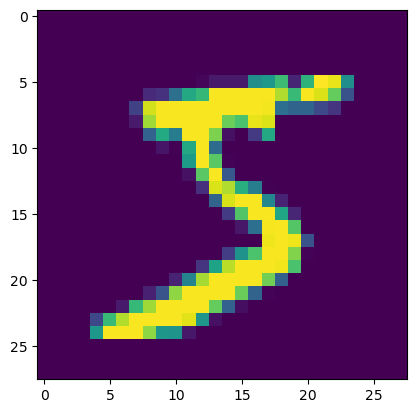

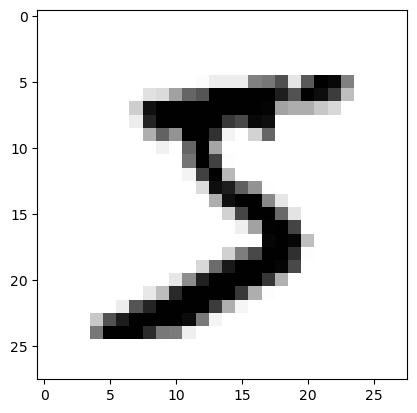

In [10]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
plt.show()

plt.imshow(x_train[0],cmap=plt.cm.binary)

In [11]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [12]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert labels to one hot vectors
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Define the model
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))  # Preventing overfitting
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Create callbacks
checkpointer = ModelCheckpoint(filepath='best_model.keras', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=50, 
                    validation_split=0.2, callbacks=[checkpointer, reduce_lr, early_stopping], 
                    verbose=1, shuffle=True)

# Load the best model after training
model = tf.keras.models.load_model('best_model.keras')

# Evaluate accuracy after training
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100 * score[1]
print("After training, test accuracy is", accuracy)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 669706

In [17]:
import cv2
import numpy as np
from collections import deque

import tensorflow as tf

# Define color boundaries for blue
blueLower = np.array([70, 50, 50])
blueUpper = np.array([90, 255, 255])

# Create kernel for morphological transformations
kernel = np.ones((5, 5), np.uint8)

# Initialize deque to store points
points = deque(maxlen=512)

# Initialize blackboard to draw on
blackboard = np.zeros((480, 640, 3), dtype=np.uint8)

# Load your model
model = tf.keras.models.load_model('best_model1.keras')  # Replace 'your_model_path.h5' with your model path

# Define letters (adjust this as per your model's output)
letters = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9'}

# Initialize a list to store recognized alphabets
recognized_alphabets = []

cap = cv2.VideoCapture(0)
prediction = 26

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
     
    # Detecting which pixel value falls under blue color boundaries
    blue = cv2.inRange(hsv, blueLower, blueUpper)
     
    # Erosion, opening, and dilation
    blue = cv2.erode(blue, kernel)
    blue = cv2.morphologyEx(blue, cv2.MORPH_OPEN, kernel)
    blue = cv2.dilate(blue, kernel)
     
    # Find contours in the image
    cnts, _ = cv2.findContours(blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      
    center = None
     
    # If any contours were found
    if len(cnts) > 0:
        cnt = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
        ((x, y), radius) = cv2.minEnclosingCircle(cnt)
        cv2.circle(frame, (int(x), int(y)), int(radius), (125, 344, 278), 2)
         
        M = cv2.moments(cnt)
        center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
     
        points.appendleft(center)
         
    elif len(cnts) == 0:
        if len(points) != 0:
            blackboard_gray = cv2.cvtColor(blackboard, cv2.COLOR_BGR2GRAY)
            blur = cv2.medianBlur(blackboard_gray, 15)
            blur = cv2.GaussianBlur(blur, (5, 5), 0)
            thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            cv2.imshow("Thresh", thresh)
             
            blackboard_cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
             
            if len(blackboard_cnts) >= 1:
                cnt = sorted(blackboard_cnts, key=cv2.contourArea, reverse=True)[0]
                 
                if cv2.contourArea(cnt) > 1000:
                    x, y, w, h = cv2.boundingRect(cnt)
                    alphabet = blackboard_gray[y-10:y+h+10, x-10:x+w+10]
                    try:
                        img = cv2.resize(alphabet, (28, 28))
                    except cv2.error as e:
                        continue
                     
                    img = np.array(img)
                    img = img.astype('float32') / 255
                     
                    prediction = model.predict(img.reshape(1, 28, 28))[0]
                    prediction = np.argmax(prediction)
                    
                    # Append the recognized alphabet to the list
                    recognized_alphabets.append(letters[prediction])
                     
            # Empty the point deque and also blackboard
            points = deque(maxlen=512)
            blackboard = np.zeros((480, 640, 3), dtype=np.uint8)
         
    # Connect the detected points with a line
    for i in range(1, len(points)):
        if points[i-1] is None or points[i] is None:
            continue
        cv2.line(frame, points[i-1], points[i], (0, 0, 0), 2)
        cv2.line(blackboard, points[i-1], points[i], (255, 255, 255), 8)
         
    # Ensure the prediction is within the valid range
    if 0 <= prediction < len(letters):
        cv2.putText(frame, "Prediction: " + str(letters[prediction]), (20, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
     
    cv2.imshow("Alphabet Recognition System", frame)
     
    if cv2.waitKey(1) == 13:  # if I press enter
        break

cap.release()
cv2.destroyAllWindows()

# Join the recognized alphabets into a single string and print it
recognized_string = ''.join(recognized_alphabets)
print("Recognized Alphabets:", recognized_string)


1/1 [==============================] - 0s 33ms/step
Recognized Alphabets: 55239715331235256278390558575239625780959521123844444949949


In [16]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert labels to one hot vectors
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Define the model
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # Added L2 regularization
model.add(Dropout(0.4))  # Increased dropout rate
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # Added L2 regularization
model.add(Dropout(0.4))  # Increased dropout rate
model.add(Dense(10, activation='softmax'))

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Create callbacks
checkpointer = ModelCheckpoint(filepath='best_model1.keras', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=50, 
                    validation_split=0.2, callbacks=[checkpointer, reduce_lr, early_stopping], 
                    verbose=1, shuffle=True)

# Load the best model after training
model = tf.keras.models.load_model('best_model1.keras')

# Evaluate accuracy after training
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100 * score[1]
print("After training, test accuracy is", accuracy)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 66970

Epoch 23/50
375/375 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9830
Epoch 23: val_loss improved from 0.14200 to 0.14066, saving model to best_model1.keras
375/375 [==============================] - 9s 23ms/step - loss: 0.1342 - accuracy: 0.9830 - val_loss: 0.1407 - val_accuracy: 0.9801 - lr: 2.0000e-04
Epoch 24/50
373/375 [============================>.] - ETA: 0s - loss: 0.1311 - accuracy: 0.9837
Epoch 24: val_loss did not improve from 0.14066
375/375 [==============================] - 8s 21ms/step - loss: 0.1312 - accuracy: 0.9837 - val_loss: 0.1410 - val_accuracy: 0.9808 - lr: 2.0000e-04
Epoch 25/50
374/375 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.9840
Epoch 25: val_loss improved from 0.14066 to 0.13990, saving model to best_model1.keras
375/375 [==============================] - 8s 21ms/step - loss: 0.1295 - accuracy: 0.9840 - val_loss: 0.1399 - val_accuracy: 0.9803 - lr: 2.0000e-04
Epoch 26/50
375/375 [===================

Epoch 49/50
373/375 [============================>.] - ETA: 0s - loss: 0.0922 - accuracy: 0.9913
Epoch 49: val_loss improved from 0.11603 to 0.11481, saving model to best_model1.keras
375/375 [==============================] - 8s 20ms/step - loss: 0.0921 - accuracy: 0.9913 - val_loss: 0.1148 - val_accuracy: 0.9830 - lr: 4.0000e-05
Epoch 50/50
375/375 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9912
Epoch 50: val_loss improved from 0.11481 to 0.11456, saving model to best_model1.keras
375/375 [==============================] - 8s 21ms/step - loss: 0.0921 - accuracy: 0.9912 - val_loss: 0.1146 - val_accuracy: 0.9831 - lr: 4.0000e-05
After training, test accuracy is 98.4000027179718
